## Causal analysis - propensity score matching

First we load the necessary modules and define a number of helper functions that will take care of estimating the propensity model, the matching procedure and visualisation.

In [205]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os

def estimate_propensity(formula, data, show_summary=False):
    model = smf.glm(formula=formula, data=data, family=sma.families.Binomial()).fit()

    if show_summary:
        print(model.summary())

    return pd.Series(data=model.predict(data), index=data.index)


def matching(label, propensity, calipher=0.05, replace=True):
    """ Nearest-neighbour matching

    Parameters:
    -----------
        label: Pandas Series that contains the label for each observation.
        propensity: Pandas Series that contains the propensity score for each observation.
        calipher: Bound on distance between observations in terms of propensity score.
        replace: Boolean that indicates whether sampling is with (True) or without replacement (False).
    """

    treated = propensity[label == 1]
    control = propensity[label == 0]

    # Randomly permute in case of sampling without replacement to remove any bias arising from the
    # ordering of the data set
    matching_order = np.random.permutation(label[label == 1].index)
    matches = {}

    for obs in matching_order:
        # Compute the distance between the treatment observation and all candidate controls in terms of
        # propensity score
        distance = abs(treated[obs] - control)

        # Take the closest match
        if distance.min() <= calipher or not calipher:
            matches[obs] = [distance.argmin()]
            
            # Remove the matched control from the set of candidate controls in case of sampling without replacement
            if not replace:
                control = control.drop(matches[obs])

    return matches

                            
def matching_to_dataframe(match, covariates, remove_duplicates=False):
    """ Converts matches to Pandas DataFrame

    Parameters:
    -----------
        match: Result from matching()
        covariates: Pandas dataframe that contains the covariate data.
        remove_duplicates: Boolean that indicates whether or not to remove duplicate rows from the result.
            Duplicate rows are controls that where matched multiple times.
            ****If matching with replacement was used you should set this to False****
    """
    treated = list(match.keys())
    control = [ctrl for matched_list in match.values() for ctrl in matched_list]

    result = pd.concat([covariates.loc[treated], covariates.loc[control]])

    if remove_duplicates:
        return result.groupby(result.index).first()
    else:
        return result
     

def trim_common_support(data, label_name):
    group_min_max = (data.groupby(label_name)
                         .propensity.agg({"min_propensity": np.min, "max_propensity": np.max}))

    # Compute boundaries of common support between the two propensity score distributions
    min_common_support = np.max(group_min_max.min_propensity)
    max_common_support = np.min(group_min_max.max_propensity)

    common_support = (data.propensity >= min_common_support) & (data.propensity <= max_common_support)
    control = (data[label_name] == 0)
    treated = (data[label_name] == 1)
    
    return data[common_support]

def qq_plot(x, y, variable_name):
    q = np.arange(0, 100)
    a = np.percentile(a=x, q=q)
    b = np.percentile(a=y, q=q)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.title("QQ-plot of variable %s" % variable_name)
        
    plt.plot(a, b, 'o')
    plt.plot([0, np.max(a)], [0, np.max(a)], '-')
    
    ax.set_xlabel("Control quantiles")
    ax.set_ylabel("Treatment quantiles")

## LaLonde data set

To illustrate the idea of propensity score matching methods, we will look at a data set from Robert Lalonde, *"Evaluating the Econometric Evaluations of Training Programs"*, American Economic Review, Vol. 76, pp. 604-620. The study looked at what the effectives of a job training programme (the treatment) was on the real earnings a couple years later. 

The data consists of a number of demographic variables (age, race, academic background, and previous real earnings), as well as a treatment indicator and the real earnings in the year 1978 (the response).

In [195]:
# Import the LaLonde data set
lalonde = pd.read_csv("lalonde.csv", index_col=0)
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


We can't use a t-test to assess whether or not there is a statistically significant effect of the treatment because there is selection bias in our sample. People with lower income tend to participate relatively more in the job program. 

treat
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: re74, dtype: object

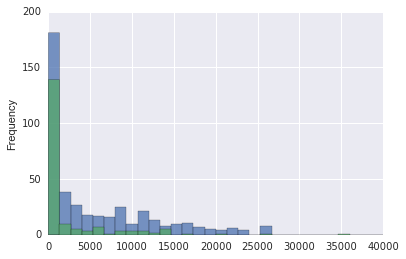

In [160]:
lalonde.groupby("treat")["re74"].plot(kind="hist", sharex=True, range=(0, 40000), bins=30, alpha=0.75)

treat
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: re75, dtype: object

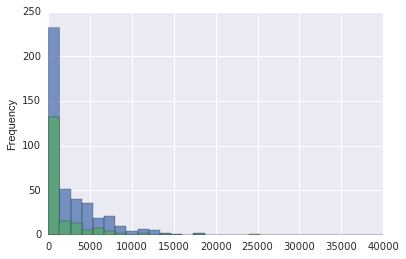

In [161]:
lalonde.groupby("treat")["re75"].plot(kind="hist", sharex=True, range=(0, 40000), bins=30, alpha=0.75)

## Propensity score matching

To make a fair comparison between the treatment and control groups, we need to remove the selection bias in our sample. This is where propensity score matching methods come in. First, we estimate a model that computes the propensity that an observation is going to participate, based on some of the (imbalanced) covariates.

One word of warning: you should only use covariates that contain information about the observations **prior** to the treatment. Otherwise, there will be leakage of post-treatment information into your propensity model, and the distribution of your propensity scores will not reflect the true distribution.

For simplicity, we will put all the covariates into the propensity model. In reality, you should iterate on your selection of covariates for the propensity score model and use the set of variables that results in a sufficient reduction of the imbalance in your data set.

In [197]:
propensity_model_covariates = ['age', 'educ', 'black', 'hispan', 
                               'married', 'nodegree', 're74', 're75',
                               'I(age^2)', 'I(educ^2)', 'I(re74 ** 2)', 'I(re75 ** 2)', 're74 * black']

propensity_model_formula = "treat ~ " + " + ".join(propensity_model_covariates)

lalonde["propensity"] = estimate_propensity(formula=propensity_model_formula, 
                                            data=lalonde, 
                                            show_summary=True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  treat   No. Observations:                  614
Model:                            GLM   Df Residuals:                      600
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -238.64
Date:                Sun, 14 Aug 2016   Deviance:                       477.29
Time:                        13:09:28   Pearson chi2:                     558.
No. Iterations:                     9                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -4.7527      1.232     -3.859      0.000        -7.166    -2.339
age              0.0835      0.058      1.436 

Let's have a look at the distribution of the propensity scores between the treatment and control group. 

treat
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: propensity, dtype: object

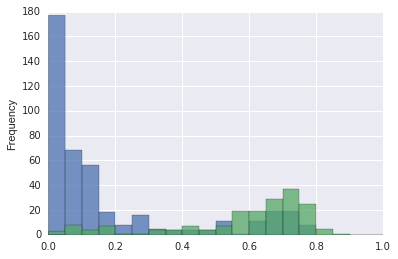

In [198]:
lalonde.groupby("treat")["propensity"].plot(kind="hist", sharex=True, range=(0, 1), bins=20, alpha = 0.75)

From the above histogram, the imbalance in our sample is clearly visible. Given the covariates, the treatment group is much more susceptible to receive treatment than the control group. The propensity score matching method will try to ensure the distribution of the propensity scores for both groups is similar to each other.

However, before we continue further we need to trim the set of observations to the so-called *common support* of the propensity score distribution. The common support is the intersection of the support of the propensity score distribution for the two groups. This preprocessing step is done because for observations that don't fall in the common support, we can't find a matching observation with a similar propensity score.

treat
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: propensity, dtype: object

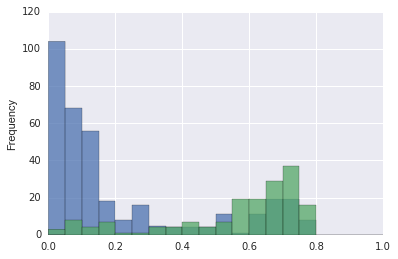

In [199]:
common_support = trim_common_support(lalonde, "treat")

# Plot the resulting propensity score distribution to make sure we restricted ourselves to the common support
common_support.groupby("treat")["propensity"].plot(kind="hist", sharex=True, range=(0, 1), bins=20, alpha = 0.75)

Finally, we are ready to apply our propensity score matching method to the data. We will use a 1-nearest neighbour matching aproach with replacement, and a calipher equal to $0.05$. Again, these parameters are something you should iterate on in reality.

In [215]:
matches = matching(label=common_support.treat,
                   propensity=common_support.propensity,
                   calipher=0.01,
                   replace=True)

In [216]:
# Did everybody get a match?
sum([True if match == [] else False for match in matches]) == 0

True

Finally, we convert the matches back to a data frame with the original covariates and inspect the resulting distribution of our pre-treatment covariates.

treat
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: propensity, dtype: object

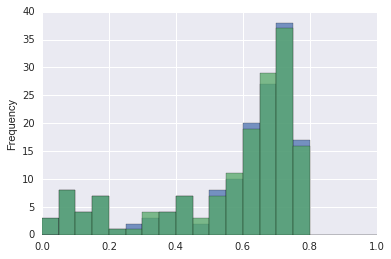

In [217]:
matches_data_frame = matching_to_dataframe(match=matches,
                                           covariates=common_support,
                                           remove_duplicates=False)

matches_data_frame.groupby("treat")["propensity"].plot(kind="hist", sharex=True, range=(0,1), bins=20, alpha=0.75)

We see that the distribution of the propensity scores are much more similar after the matching, compared to before the matching. We should also check if the matching improved the balance in our covariates. There are multiple ways of checking this balance:

* Comparing means and standard deviations between the treatment and control groups across the covariates.
* QQ-plots of the distributions of the covariates between the treatment and control groups.
* LOWESS plots where we compare the expected value of a covariate $X$ between the treatment and control groups for every value of the propensity score. 

In real-world problems you should continuously check these plots and iterate with your propensity model and matching method until you achieve a sufficient balance in your covariates.

## Comparings means and standard deviations

In [218]:
vars_to_compare = ["propensity", "re74", "re75"]
matches_data_frame.groupby("treat")[vars_to_compare].agg([np.mean, np.std])

propensity                   re74                      re75             
            mean       std         mean          std         mean          std
treat                                                                         
0       0.563970  0.215311  2389.222552  4527.054689  1691.309899  3054.155447
1       0.563374  0.215430  1950.070078  4285.231922  1396.405241  2678.380725

## Comparing QQ-plots

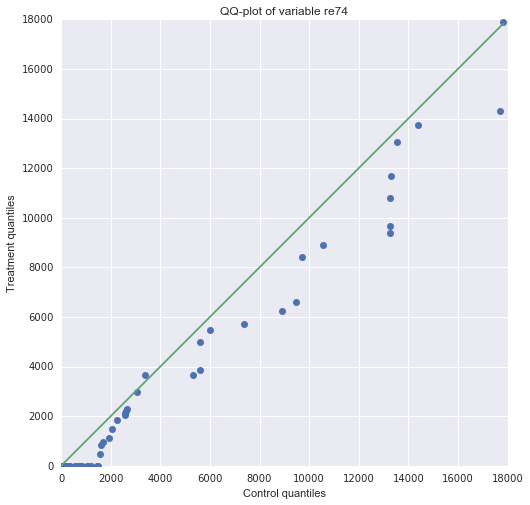

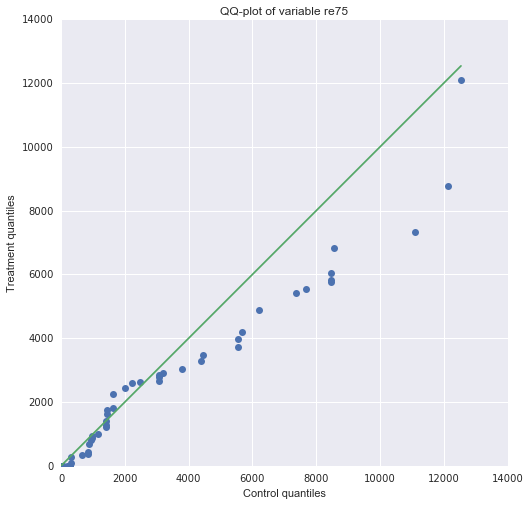

In [219]:
vars_to_plot = ["re74", "re75"]

for var in vars_to_plot:
    control = matches_data_frame[matches_data_frame.treat == 0][var]
    treat = matches_data_frame[matches_data_frame.treat == 1][var]
    
    qq_plot(control, treat, var)

## Comparing LOWESS plots

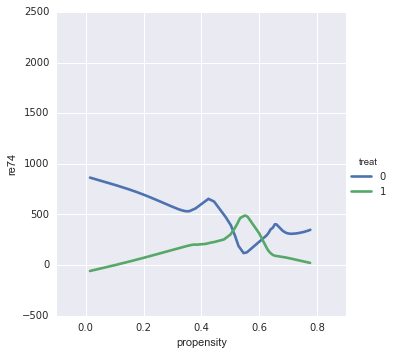

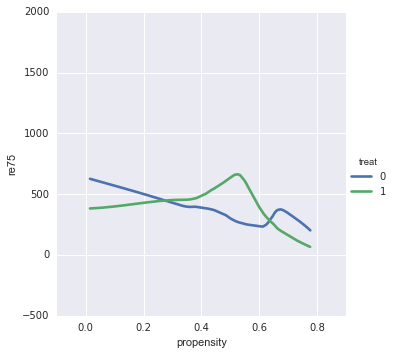

In [220]:
def loess_plots(matches_data_frame, balance_covariates, label_name):
    for covariate in balance_covariates:
        plt.figure()
        sns.lmplot(data=matches_data_frame,
                   x="propensity",
                   y=covariate,
                   hue=label_name,
                   scatter=False, 
                   lowess=True)
        
loess_plots(matches_data_frame, vars_to_plot, label_name="treat")

## Comparing histograms

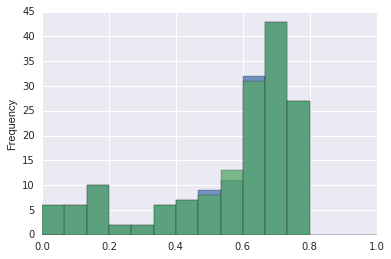

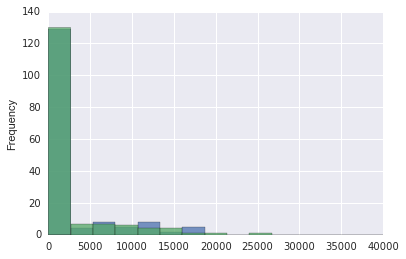

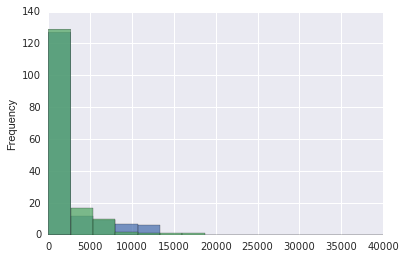

In [221]:
vars_to_plot = ["propensity", "re74", "re75"]
vars_range = {"propensity": (0, 1),
              "re74": (0, 40000),
              "re75": (0, 40000)}

for var in vars_to_plot:
    fig, ax = plt.subplots()
    matches_data_frame.groupby("treat")[var].plot(kind="hist", sharex=True, range=vars_range[var], bins=15, alpha=0.75)

## Average treatment effect

Since the data set is now balanced on the pre-treatment covariates, we are now able to accurately compute the treatment effect by means of a t-test for a difference in means. The null hypothesis is that there is no statistically significant difference in mean real earnings in 1978 between the test and control groups, and we will test at a significance level $\alpha = 0.05$. 

In [222]:
print(smf.ols(formula='re78 ~ treat', data=matches_data_frame).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4436
Date:                Sun, 14 Aug 2016   Prob (F-statistic):              0.506
Time:                        13:13:39   Log-Likelihood:                -3324.4
No. Observations:                 322   AIC:                             6653.
Df Residuals:                     320   BIC:                             6660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5851.8429    582.719     10.042      0.0